Load in resources

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load the Data

Define the start date, end date, and stock tickers

In [2]:
import time
from datetime import datetime

start_date = '01/01/2014'
end_date = '12/31/2019'

start_timestamp = int(time.mktime(datetime.strptime(start_date, '%m/%d/%Y').timetuple()))
end_timestamp = int(time.mktime(datetime.strptime(end_date, '%m/%d/%Y').timetuple()))

stock_tickers = ['AAPL', 'MSFT', 'INTC', 'CSCO', 'ADBE', 'CRM', 'NVDA', 'ACN', 'PYPL', 'ORCL']


Get the data from Yahoo Finance

In [3]:
from requests import request
import json

def create_dataframe(response, symbol):
    df = pd.DataFrame(json.loads(response.text)['prices'])
    df = df[['date', 'adjclose']].copy()
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df = df.dropna()
    df = df.set_index('date')
    df.sort_index(inplace=True, ascending=True)
    return df

def load_historical_data(freq, start, end, symbol):
    url = 'https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-historical-data'
    
    query_string = {'frequency':freq,
                    'filter':'history',
                    'period1':start,
                    'period2':end,
                    'symbol':symbol
                   }
    
    headers = {'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
               'x-rapidapi-key': "05f54dc788msh8e1cd501d7fc5aep13ed11jsn66185aeadb19"
              }
    
    response = request('GET', url, headers=headers, params=query_string)
    
    return create_dataframe(response, symbol)

Save the data in a dictionary

In [4]:
data_frames = {}

for ticker in stock_tickers:
    data_frames[ticker] = load_historical_data('1d', start_timestamp, end_timestamp, ticker)
    print(ticker, len(data_frames[ticker]))


AAPL 1509
MSFT 1509
INTC 1509
CSCO 1509
ADBE 1509
CRM 1509
NVDA 1509
ACN 1509
PYPL 1131
ORCL 1509


In [48]:
train_start = start_timestamp
train_start_dt = datetime.fromtimestamp(train_start)
train_end = int(time.mktime(datetime.strptime('12/31/2018', '%m/%d/%Y').timetuple()))
train_end_dt = datetime.fromtimestamp(train_end)

test_start = int(time.mktime(datetime.strptime('01/01/2019', '%m/%d/%Y').timetuple()))
test_start_dt = datetime.fromtimestamp(test_start)
test_end = int(time.mktime(datetime.strptime('12/31/2019', '%m/%d/%Y').timetuple()))
test_end_dt = datetime.fromtimestamp(test_end)

# Prepare the Data for DeepAR

Separate the training data

In [74]:
def train_data(complete_dict, start_date, end_date):
    train_dict = {}
    for key, value in complete_dict.items():
        train_dict[key] = value.loc[start_date:end_date]
    return train_dict

## Save the data locally as JSON Lines

In [70]:
import os

data_dir = 'json_stock_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [76]:
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

Convert to JSON Lines

In [80]:
def write_json_dataset(complete_dict, filename):
    with open(filename, 'wb') as f:
        for value in complete_dict.values():
            json_obj = {'start': str(value.index[0]), 'target': list(value.adjclose)}
            json_line = json.dumps(json_obj) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [82]:
training_data = train_data(data_frames, train_start_dt, train_end_dt)

write_json_dataset(training_data, train_key)
write_json_dataset(data_frames, test_key)

json_stock_data/train.json saved.
json_stock_data/test.json saved.


## Upload the data to S3

In [83]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [85]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

In [86]:
prefix = 'capstone-stock-data'

train_prefix = f'{prefix}/train'
test_prefix = f'{prefix}/test'

train_path = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path = sagemaker_session.upload_data(test_key, bucket=bucket, key_prefix=test_prefix)

# Training DeepAR Estimator

Configure the container image

In [88]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

Instantiate the Estimator

In [89]:
from sagemaker.estimator import Estimator

s3_output_path = f's3://{bucket}/{prefix}/output'

estimator = Estimator(sagemaker_session = sagemaker_session,
                      image_name = image_name,
                      role = role,
                      train_instance_count = 1,
                      train_instance_type = 'ml.c4.xlarge',
                      output_path = s3_output_path
                      )

Set Hyperparameters

In [119]:
hyperparameters = {
    'epochs': '50',
    'time_freq': 'D',
    'prediction_length': '30', # Trading days in 2019
    'context_length': '30', # Trading days in 2019
    'num_cells': '50',
    'early_stopping_patience': '10'
}

estimator.set_hyperparameters(**hyperparameters)

Launch Training Job

In [120]:
%%time
data_channels = {
    'train': train_path,
    'test': test_path
}

estimator.fit(inputs=data_channels)

2020-02-17 18:16:51 Starting - Starting the training job...
2020-02-17 18:16:52 Starting - Launching requested ML instances......
2020-02-17 18:17:56 Starting - Preparing the instances for training......
2020-02-17 18:19:06 Downloading - Downloading input data...
2020-02-17 18:19:42 Training - Training image download completed. Training in progress.Arguments: train
[02/17/2020 18:19:45 INFO 139735716734784] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': 

# Deploy and Create a Predictor

Create a Predictor

In [123]:
%%time
predictor = estimator.deploy(initial_instance_count = 1,
                             instance_type = 'ml.t2.medium',
                             content_type = 'application/json'
                             )

Using already existing model: forecasting-deepar-2020-02-17-18-16-51-029


-----------------------!CPU times: user 401 ms, sys: 8.96 ms, total: 410 ms
Wall time: 11min 32s


In [124]:
def series_to_json_obj(ts):
    json_obj = {'start': str(ts.index[0]), 'target': list(ts)}
    return json_obj

In [125]:
def json_predictor_input(input_ts, num_samples=50, quantiles=['0.1','0.5','0.9']):
    
    instances = []
    
    for value in input_ts.values():
        instances.append(series_to_json_obj(value.adjclose))
        
    configuration = {'num_samples': num_samples,
                     'output_types': ['quantiles'],
                     'quantiles': quantiles
                    }
    
    request_data = {'instances': instances,
                    'configuration': configuration
                   }
    
    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

In [126]:
input_ts = training_data
target_ts = data_frames

json_input_ts = json_predictor_input(input_ts)
json_prediction = predictor.predict(json_input_ts)

In [127]:
def decode_prediction(prediction, encoding='utf-8'):
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list

In [128]:
prediction_list = decode_prediction(json_prediction)

print(prediction_list[0])

           0.1         0.9         0.5
0   145.750793  156.340454  150.875854
1   147.810425  156.499802  151.884186
2   147.859406  157.971497  152.507385
3   148.155853  160.732361  153.708694
4   148.625259  157.545670  152.812714
5   146.723907  158.452560  153.523972
6   149.150055  157.430328  153.119690
7   148.353119  159.579361  153.405975
8   148.060379  159.131012  153.169769
9   147.770309  160.938446  152.192368
10  147.013992  158.172836  152.229111
11  146.461472  160.588196  154.157440
12  144.696213  161.383255  152.786072
13  147.230957  161.614655  152.920197
14  149.233887  161.986984  154.862839
15  148.165100  162.970184  154.881760
16  145.734177  161.949097  154.435379
17  149.528183  162.315598  154.910889
18  149.224319  164.488327  153.920761
19  147.506378  163.700073  154.824738
20  149.090744  167.598740  154.830338
21  148.882492  163.745010  153.969315
22  149.454910  164.592056  156.734238
23  149.492233  166.925079  157.759674
24  149.225418  166.91697

In [129]:
def display_quantiles(prediction_list, target_ts=None):
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        if target_ts is not None:
            target = target_ts[k][-259:-229]
            plt.plot(range(len(target)), target, label='target')
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

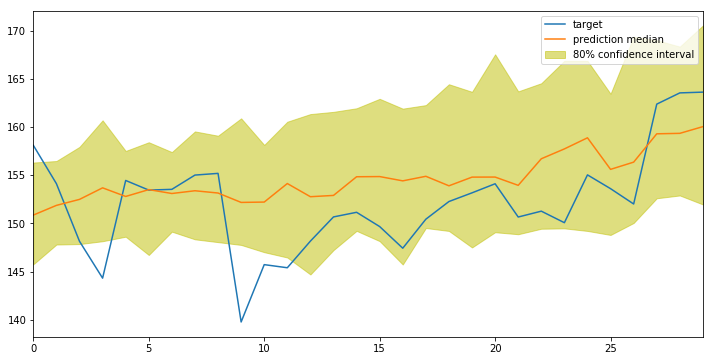

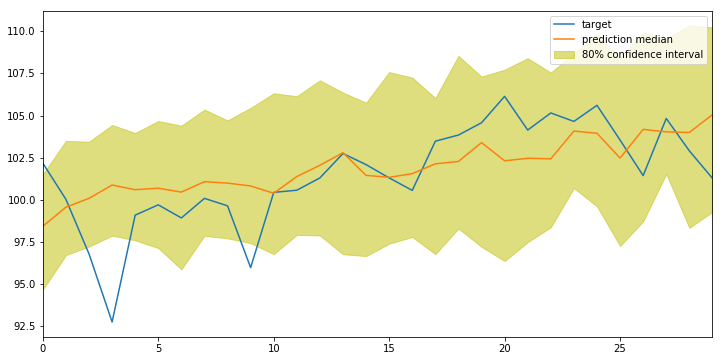

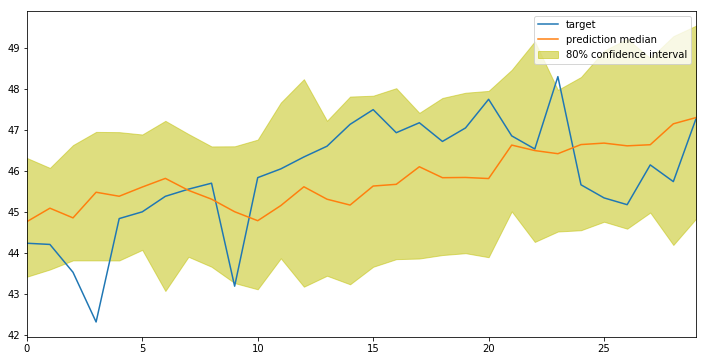

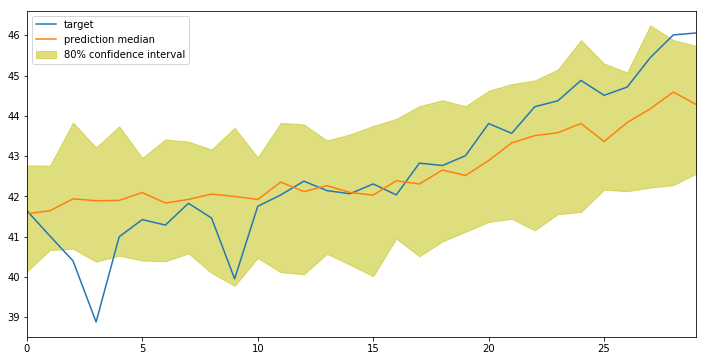

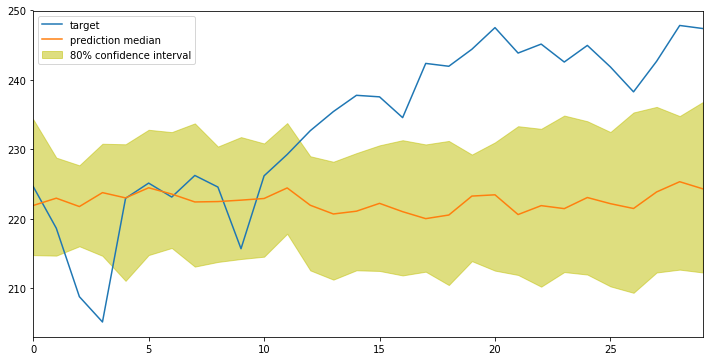

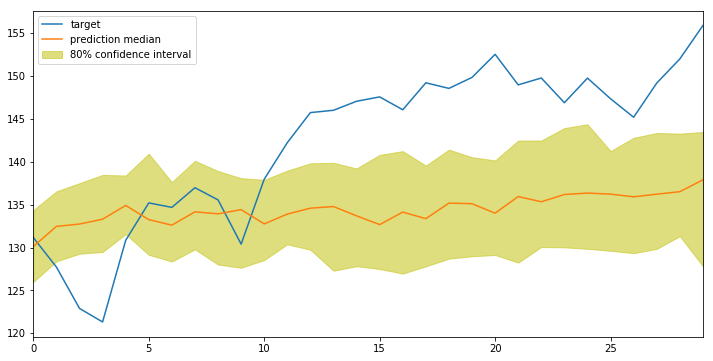

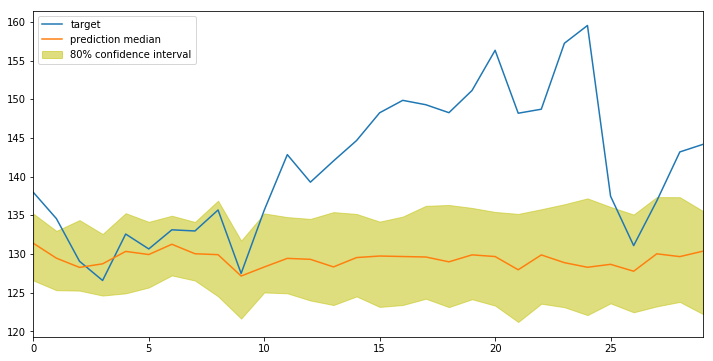

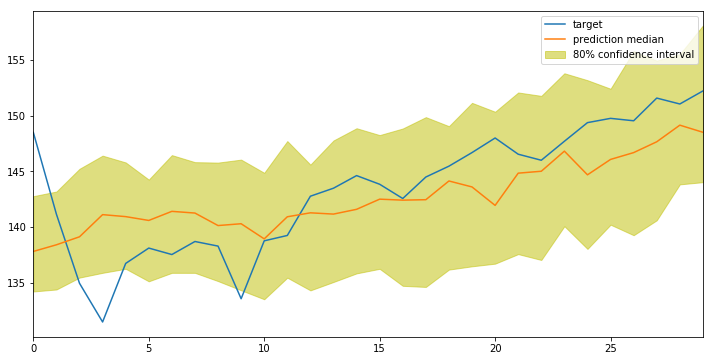

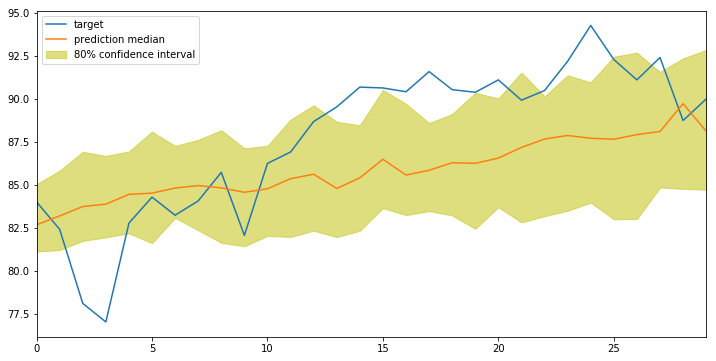

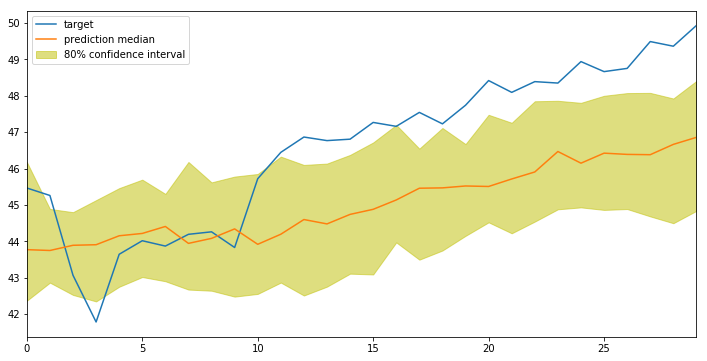

In [133]:
target_values = [list(values.adjclose) for values in target_ts.values()]
display_quantiles(prediction_list, target_values)

In [138]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

In [156]:
for k in range(len(prediction_list)):
    data = {'target': target_values[k][-259:-229], 'trailing': target_values[k][-260], 'pred': list(prediction_list[k]['0.5'])}
    df = pd.DataFrame(data)
    trail_mape = mape(list(df.target), list(df.trailing))
    pred_mape = mape(list(df.target), list(df.pred))
    print(stock_tickers[k])
    print('Trailing:', trail_mape)
    print('Prediction:', pred_mape)
    print('-'*20)

AAPL
Trailing: 7.380615087499606
Prediction: 2.7910879832864635
--------------------
MSFT
Trailing: 2.410870347549741
Prediction: 1.8047097009865616
--------------------
INTC
Trailing: 2.4930019697956993
Prediction: 2.3148040875896414
--------------------
CSCO
Trailing: 3.316989047239774
Prediction: 1.8035950946497383
--------------------
ADBE
Trailing: 4.90638200711394
Prediction: 5.762257855644683
--------------------
CRM
Trailing: 8.088786893063842
Prediction: 6.916601092047745
--------------------
NVDA
Trailing: 6.393355840579992
Prediction: 8.110881565433038
--------------------
ACN
Trailing: 4.765762789148114
Prediction: 2.2429710961746356
--------------------
PYPL
Trailing: 4.9099942069889515
Prediction: 3.683596786906071
--------------------
ORCL
Trailing: 5.039090322408645
Prediction: 3.902380472941499
--------------------
